## Gene similarity

In [1]:
import os

#retrieves gene from a file in FASTA format
def readGene(filename):
    with open(filename, 'r') as f:
        data = f.read()
    return data[data.find('\n'):].replace('\n','')
    
    
#runs the GenCompress algorithm on the given gene and returns the size of the output
def compressGene(gene,condition):
    with open('tmp','w') as tmp:
        tmp.write(gene)
        if condition:
            with open('tmp_cond','w') as tmp_cond:
                tmp_cond.write(condition)
                os.system('./GenCompress tmp -c tmp_cond')
        else:
            os.system('./GenCompress tmp')
    size = os.stat('./tmp.GEN').st_size
    os.remove('./tmp')
    os.remove('./tmp.GEN')
    os.remove('./tmp.LOG')
    if condition:
        os.remove('./tmp_cond')
    return size

#returns similarity(distance) of the given genes
def geneSimilarity(uFile,vFile):
    u = readGene(uFile)
    v = readGene(vFile)
    cu = compressGene(u,None)
    cuv = compressGene(u+v,None)
    cu_v = compressGene(u,v)
    return 1 - 1.0*(cu - cu_v)/cuv

## Similarity matrix

In [2]:
import numpy as np
import sys
import os

filenames = []

def getNumber(filename):
    name = filename[filename.rfind(os.path.sep)+1:]
    return int(name[:name.find('.')])

for root, _, files in os.walk('genes'):      
    for filename in files:
        if(filename.endswith('.fasta')):
            filenames.append(os.path.join(root,filename))
            
size = len(filenames)
print('Found '+str(size)+' species')
simMatrix = np.zeros((size,size))

total = int(size*size-size)
done = 0

for i in range(0,size):
    for j in range(0,size):
        if i != j:
            uFile = filenames[i];
            vFile = filenames[j];
            uIndex = getNumber(uFile)-1
            vIndex = getNumber(vFile)-1
            simMatrix[uIndex,vIndex] = geneSimilarity(uFile,vFile)
            simMatrix[vIndex,uIndex] = geneSimilarity(vFile,uFile)
            done += 1
            sys.stdout.write("\rCalculating similarity {}/{}".format(done,total))
            sys.stdout.flush()
print('\nDone')

Found 29 species
Calculating similarity 812/812
Done


## Nearest neighbours

In [68]:
from tabulate import tabulate

simTmp = simMatrix.copy()
for i in range(0,size):
    simTmp[i,i]=1

nn = np.argmin(simTmp,0)

with open('species','r') as speciesFile:
    species = speciesFile.read().split('\n')[:-1]

width = max([len(s) for s in species]) + 1

nnPairs = [(species[i],species[nn[i]]) for i in range(0,size)]

print(tabulate(nnPairs,headers=['Species','Nearest neighbour'],tablefmt="fancy_grid"))


╒═══════════════════╤═════════════════════╕
│ Species           │ Nearest neighbour   │
╞═══════════════════╪═════════════════════╡
│ baboon            │ gibbon              │
├───────────────────┼─────────────────────┤
│ cat               │ harbor seal         │
├───────────────────┼─────────────────────┤
│ common chimpanzee │ bonobo chimpanzee   │
├───────────────────┼─────────────────────┤
│ bonobo chimpanzee │ common chimpanzee   │
├───────────────────┼─────────────────────┤
│ cow               │ sheep               │
├───────────────────┼─────────────────────┤
│ dog               │ gray seal           │
├───────────────────┼─────────────────────┤
│ donkey            │ horse               │
├───────────────────┼─────────────────────┤
│ fat dormouse      │ squirrel            │
├───────────────────┼─────────────────────┤
│ gibbon            │ common chimpanzee   │
├───────────────────┼─────────────────────┤
│ gorilla           │ common chimpanzee   │
├───────────────────┼───────────

## Download and resize images

In [4]:
import os
import shutil # used for 'rm -r'
import sys
import json
from io import StringIO
from PIL import Image
from urllib.request import FancyURLopener
import requests

imagesDir = './images/'
tmpDir = "./tmp915667/"
if not os.path.exists(tmpDir):
    os.makedirs(tmpDir)
if not os.path.exists(imagesDir):
    os.makedirs(imagesDir)

with open('species','r') as speciesFile:
    species = speciesFile.read().split('\n')[:-1]

def getImageUrl(keyword):
    searchTerm = keyword
    startIndex = "0"
    searchUrl = "http://ajax.googleapis.com/ajax/services/search/images?v=1.0&q=" + searchTerm + "&start=" + startIndex
    
    jsonFile = requests.get(searchUrl).json()
    imageUrl = jsonFile['responseData']['results'][0]['unescapedUrl']
    return imageUrl

# Http header must be changed because some websites don't allow downloading image to robots
class MyOpener(FancyURLopener):
    version = 'Mozilla/5.0 (Windows; U; Windows NT 5.1; it; rv:1.8.1.11) Gecko/20071127 Firefox/2.0.0.11'

def downloadImage(imageUrl, searchTerm):
    myopener = MyOpener()
    tmpImagePath = tmpDir + searchTerm
    myopener.retrieve(imageUrl, tmpImagePath)
    return tmpImagePath

total = len(species)
current = 1
for searchTerm in species:
    sys.stdout.write("\rDownloading image of " + searchTerm + " ... " + "{}/{}\n".format(current,total))
    sys.stdout.flush()
    imageUrl = getImageUrl(searchTerm)
    tmpImagePath = downloadImage(imageUrl, searchTerm)
    resImagePath = imagesDir + searchTerm + ".png"
    Image.open(tmpImagePath).resize((300, 200), Image.BILINEAR).save(resImagePath)
    current += 1

shutil.rmtree(tmpDir)
print("Done")


Done


/usr/lib64/python3.4/site-packages/ipykernel/__main__.py:34: DeprecationWarning: MyOpener style of invoking requests is deprecated. Use newer urlopen functions/methods


## Visualization of similarity

In [25]:
from pygraphviz import AGraph


# Scaled simMatrix for longer edges in image
distMatrix = 9 * simMatrix * np.array(simMatrix >= 0, dtype=int)


def add_nodes(G):
    for y in range(size):
        G.add_node(y, image="{}{}.png".format(imagesDir, species[y]),
                   xlabel=species[y],
                   shape="rectange",
                   fontsize=50,
                   label=""
                  )

# Add edges to graph G, if they are shorter than edge_threshold
def add_edges(G, edge_threshold=1):
    for y in range(size):
        for x in range(y+1, size):
            if simMatrix[y, x] < edge_threshold:
                #print("Adding edge {} -- {}".format(species[y], species[x]))
                G.add_edge(y, x, len=distMatrix[y, x])
                
# Generate a graph description for graphviz, adding one node at a time
def create_graph_png(G, filename, vis="neato"):
    aux = "aux.dot"
    with open(aux, "w") as fout:
        print(G, file=fout)
    # Pygraphviz drawing method has some bug and won't tell us what is wrong 
    # with our graph description and won't generate anything even if graphviz only gives a warning.
    # Therefore we are calling graphviz through os.system().
    os.system("{} -Tpng -o {} {}".format(vis, filename, aux))

   
    
# Graph with nodes
gwn = AGraph()
add_nodes(gwn)

# Complete graph
G = gwn.copy()
add_edges(G, 1)
create_graph_png(G, "graph.png")

# Graph with edges shorter than threshold only
G = gwn.copy()
add_edges(G, 0.96)
create_graph_png(G, "graph-threshold.png")

# Graph with edges for five closest nodes for each animal
# Edge to the closest one is a bit thicker
G = gwn.copy()
for y in range(size):
    sorting_indices = simMatrix[y].argsort()
    first = True
    # the first edge will probably be a loop (we will skip it)
    for x in sorting_indices[:6]:
        if x == y:
            continue
        kwargs = {}
        if first:
            kwargs = {"penwidth": 3}
            first = False
        G.add_edge(y, x, len=distMatrix[y, x], **kwargs)
create_graph_png(G, "graph-five.png")


![graphcomplete](graph.png)

![graphthreshold](graph-threshold.png)

![graphfive](graph-five.png)

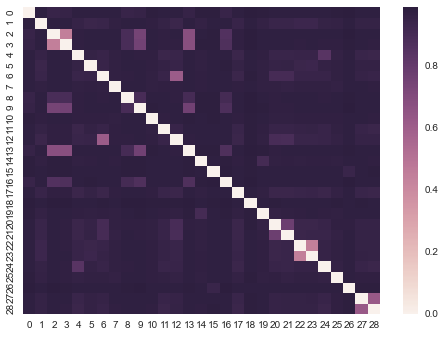

In [67]:
import seaborn as sns
%matplotlib inline
sns.set()

sns.heatmap(simMatrix)


## Phylogenetics tree

In [26]:
import subprocess

def safeRemove(path):
    if os.path.isfile(path):
        os.remove(path)
        
def shortName(name):
    return name.replace(" ","")[:7]

limit = size
safeRemove('outfile')
safeRemove('outtree')
with open('infile','w') as tmp:
    tmp.write("    "+str(limit)+"\n")
    for i in range(limit):
        name = shortName(species[i])
        tmp.write(name+(" "*(12-len(name))))
        for j in range(limit):
            tmp.write("  {:.4f}".format(min(simMatrix[i,j],simMatrix[j,i])))
        tmp.write("\n")
p = subprocess.Popen(['./neighbor','f'],stdout=subprocess.PIPE,stdin=subprocess.PIPE)
p.stdin.write('Y\n')
p.stdin.close()
p.wait()

with open('outfile','r') as res:
    data = res.read()
    data = data[data.find('allowed')+7:data.find('remember')]
    for i in range(size):
        data = data.replace(shortName(species[i]),species[i])
    print(data)
    
with open('outtree','r') as res:
    tree = res.read()
    
print(tree)
    
safeRemove('outfile')
safeRemove('outtree')
safeRemove('infile')

TypeError: 'str' does not support the buffer interface

## Phylogenetics tree visualization

In [29]:
# Directed graph with nodes
dgwn = AGraph(directed=True)
add_nodes(dgwn)

# a tree coded in tuples, leaves are strings (names of the species)
with open("phtree2.txt", "r") as fin:
    tree_s = fin.read()
tree = eval(tree_s)

# function reportedly used in generating names in phtree2.txt
def shortName(name):
    return name.replace(" ","")[:7]
species_ids = {shortName(name): i for i, name in enumerate(species)}

# Add nodes and edges to AGraph ``G`` so that it corresponds to the phylogenetic tree ``tree``
# Should be called with ``parent = None`` 
def graph_tree(tree, parent, G):
    edge_len = 5

    if type(tree) == str:
        G.add_edge(parent, species_ids[tree], len=edge_len)
    else:
        G.add_node(graph_tree.n_nodes)
        if parent is not None:
            G.add_edge(parent, graph_tree.n_nodes, len=edge_len)
        this_node = graph_tree.n_nodes
        graph_tree.n_nodes += 1

        for subtree in tree:
            graph_tree(subtree, this_node, G)
graph_tree.n_nodes = len(species)

graph_tree(tree, None, dgwn)
create_graph_png(G, "tree.png", vis="dot")

strict digraph {
	node [label="\N"];
	0	 [fontsize=50,
		image="./images/baboon.png",
		label="",
		shape=rectange,
		xlabel=baboon];
	1	 [fontsize=50,
		image="./images/cat.png",
		label="",
		shape=rectange,
		xlabel=cat];
	2	 [fontsize=50,
		image="./images/common chimpanzee.png",
		label="",
		shape=rectange,
		xlabel="common chimpanzee"];
	3	 [fontsize=50,
		image="./images/bonobo chimpanzee.png",
		label="",
		shape=rectange,
		xlabel="bonobo chimpanzee"];
	4	 [fontsize=50,
		image="./images/cow.png",
		label="",
		shape=rectange,
		xlabel=cow];
	5	 [fontsize=50,
		image="./images/dog.png",
		label="",
		shape=rectange,
		xlabel=dog];
	6	 [fontsize=50,
		image="./images/donkey.png",
		label="",
		shape=rectange,
		xlabel=donkey];
	7	 [fontsize=50,
		image="./images/fat dormouse.png",
		label="",
		shape=rectange,
		xlabel="fat dormouse"];
	8	 [fontsize=50,
		image="./images/gibbon.png",
		label="",
		shape=rectange,
		xlabel=gibbon];
	9	 [fontsize=50,
		image="./images/gorilla.pn

![tree](tree.png)